<a href="https://colab.research.google.com/github/seeverblog/BCDU-Ne/blob/master/model_from_scratch_double_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [20]:
os.chdir('/content/drive/My Drive/Colab Notebooks/DATA RD/')
files = glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATA1_CLAHE/*')
files2=glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATA_PREPROCESSING/*')

len (files),len(files2)

(7200, 7200)

In [21]:
train_imgs1 = [fn for fn in files]
train_imgs2 = [fn for fn in files2]
len(train_imgs1),len(train_imgs2)

(7200, 7200)

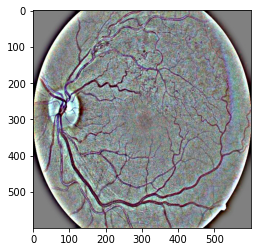

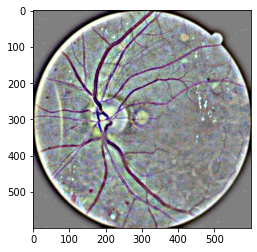

In [22]:
import matplotlib.image as mpimg
for ima in train_imgs2[0:2]:
     img=mpimg.imread(ima)
     imgplot = plt.imshow(img)
     plt.show()

In [0]:
nrows = 224
ncolumns = 224
channels = 3  

def read_and_process_image(list_of_images):
    
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'Normal' in image:
            y.append(0)
        elif 'Mild' in image:
            y.append(1)
        elif 'Moderate' in image:
            y.append(2)
        elif 'Severe' in image:
            y.append(3)

    
    return X, y

In [0]:
Xtrain1, ytrain1 = read_and_process_image(train_imgs1)
Xtrain2,ytrain2=read_and_process_image(train_imgs2)

Text(0.5, 1.0, 'Total images of each class')

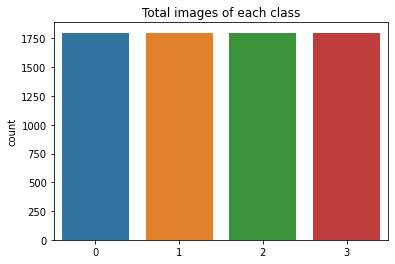

In [25]:
import seaborn as sns
import gc 
gc.collect()

#Convert list to numpy array
Xtrain1 = np.array(Xtrain1)
ytrain1 = np.array(ytrain1)

Xtrain2 = np.array(Xtrain2)
ytrain2 = np.array(ytrain2)

#Lets plot the label to be sure we just have two class
sns.countplot(ytrain1)
plt.title('Total images of each class')

In [26]:
print("Shape Data 1:", Xtrain1.shape,"Shape Data 2:",Xtrain2.shape)
print("Shape Label 1:", ytrain1.shape,"Shape Label 2:", ytrain2.shape)

Shape Data 1: (7200, 224, 224, 3) Shape Data 2: (7200, 224, 224, 3)
Shape Label 1: (7200,) Shape Label 2: (7200,)


In [0]:
from sklearn.model_selection import train_test_split
X_train1, X_val1, y_train1, y_val1 = train_test_split(Xtrain1, ytrain1, test_size=0.2,stratify=np.array(ytrain1),random_state=2)
X_train2, X_val2, y_train2, y_val2 = train_test_split(Xtrain2, ytrain2, test_size=0.2,stratify=np.array(ytrain2),random_state=2)

In [28]:
print("Shape data train 1:", X_train1.shape,"Shape data train 2:", X_train2.shape)
print("Shape data validasi 1:", X_val1.shape,"Shape data validasi 2:", X_val2.shape)
print("Shape train labels 1:", y_train1.shape,"Shape train labels 2:", y_train2.shape)
print("Shape validasi labels 1:", y_val1.shape,"Shape validasi labels 2:", y_val2.shape)

Shape data train 1: (5760, 224, 224, 3) Shape data train 2: (5760, 224, 224, 3)
Shape data validasi 1: (1440, 224, 224, 3) Shape data validasi 2: (1440, 224, 224, 3)
Shape train labels 1: (5760,) Shape train labels 2: (5760,)
Shape validasi labels 1: (1440,) Shape validasi labels 2: (1440,)


In [0]:
del Xtrain1
del ytrain1
del Xtrain2
del ytrain2
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train1)
nval = len(X_val1)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32


In [30]:
y_train1_ohe = pd.get_dummies(y_train1)
y_val1_ohe=pd.get_dummies(y_val1)
y_train2_ohe = pd.get_dummies(y_train2)
y_val2_ohe=pd.get_dummies(y_val2)

y_train1_ohe.shape,y_val1_ohe.shape,y_train2_ohe.shape,y_val2_ohe.shape

((5760, 4), (1440, 4), (5760, 4), (1440, 4))

In [0]:
BATCH_SIZE = 16
EPOCHS = 30
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [0]:
def create_convolution_layers(input_img):
  model =tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = tf.keras.layers.LeakyReLU(alpha=0.1)(model)
  model =tf.keras.layers.MaxPooling2D((2, 2),padding='same')(model)
  model =tf.keras.layers.Dropout(0.25)(model)
  
  model =tf.keras.layers.Conv2D(64, (3, 3), padding='same')(model)
  model =tf.keras.layers.LeakyReLU(alpha=0.1)(model)
  model =tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model =tf.keras.layers.Dropout(0.25)(model)
    
  model =tf.keras.layers.Conv2D(128, (3, 3), padding='same')(model)
  model =tf.keras.layers.LeakyReLU(alpha=0.1)(model)
  model =tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model =tf.keras.layers.Dropout(0.4)(model)
    
  return model

In [0]:
input_shape = (224, 224, 3)
Clahe_input =tf.keras.layers.Input(shape=input_shape)
Clahe_model = create_convolution_layers(Clahe_input)

Preproses_input =tf.keras.layers.Input(shape=input_shape)
Preproses_model = create_convolution_layers(Preproses_input)

In [0]:
conv =tf.keras.layers.concatenate([Clahe_model, Preproses_model])
conv =tf.keras.layers.Flatten()(conv)
dense =tf.keras.layers.Dense(512)(conv)
dense =tf.keras.layers.LeakyReLU(alpha=0.1)(dense)
dense =tf.keras.layers.Dropout(0.5)(dense)
output =tf.keras.layers.Dense(N_CLASSES, activation='softmax')(dense)

model =tf.keras.models.Model(inputs=[Clahe_input, Preproses_input], outputs=[output])

In [0]:
es =tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)

In [0]:
gen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                 zoom_range=[0.9, 1.1],
                                 horizontal_flip=True,
                                 vertical_flip=True)
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=666)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=666)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[1]], X1i[1]

In [0]:
gen_flow = gen_flow_for_two_inputs(X_train1, X_train2, y_train1_ohe)
val_generator = gen_flow_for_two_inputs(X_val1, X_val2, y_val1_ohe)

In [38]:
history=model.fit_generator(gen_flow, steps_per_epoch=len(X_train1) / batch_size,
                                      validation_data=val_generator,
                                      validation_steps=len(X_val1) / batch_size, 
                                      epochs=EPOCHS,callbacks=callback_list,
                                      verbose=1).history

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
180/180 [==============================] - 154s 856ms/step - loss: 63.5463 - accuracy: 0.3021 - val_loss: 52.0204 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/30
180/180 [==============================] - 152s 844ms/step - loss: 3.5105 - accuracy: 0.3198 - val_loss: 48.2620 - val_accuracy: 0.2507 - lr: 1.0000e-04
Epoch 3/30
180/180 [==============================] - 151s 840ms/step - loss: 3.0724 - accuracy: 0.3571 - val_loss: 24.5739 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 4/30
180/180 [==============================] - 150s 836ms/step - loss: 2.8437 - accuracy: 0.3802 - val_loss: 22.1878 - val_accuracy: 0.2535 - lr: 1.0000e-04
Epoch 5/30
180/180 [==============================] - 150s 833ms/step - loss: 2.6908 - accuracy: 0.3800 - val_loss: 9.2617 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 6/30
180/180 [==============================] - 149s 828ms/step - loss: 2.3961 - accuracy: 0.3929 